In [20]:
import torch
print(torch.__version__)
print(torch.backends.mps.is_available()) # GPU for mac osx
print(torch.cuda.is_available())  # Should return True if GPU is ready
device = "mps" if torch.backends.mps.is_available() else "cpu"

2.6.0
True
False


An example from https://medium.com/@heyamit10/fine-tuning-bert-for-classification-a-practical-guide-b8c1c56f252c

In [21]:
from datasets import load_dataset
import pandas as pd

# Load the IMDB dataset
dataset = load_dataset("imdb")

# Peek at the dataset structure
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


Test if data is balanced

In [22]:
test_labels = dataset["test"]["label"]
print("test\n", pd.Series(test_labels).value_counts().sort_index())
train_labels = dataset["train"]["label"]
print("train\n", pd.Series(train_labels).value_counts().sort_index())

test
 0    12500
1    12500
Name: count, dtype: int64
train
 0    12500
1    12500
Name: count, dtype: int64


Use scikit-learn to calculate class weights to calculate class imbalance

In [23]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

labels = dataset["train"]["label"]
class_weights = compute_class_weight("balanced", classes=np.unique(labels), y=labels)
print(class_weights)

[1. 1.]


Tokenization from Hugging Face

In [24]:
from transformers import AutoTokenizer

# Initialize the BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Tokenize a sample text
sample_text = "I absolutely loved this movie! Highly recommend it."

# Padding and truncation ensures inputs of the same length
# setting to max_length too large may wastes memory; 128-256 works well
tokens = tokenizer(sample_text, padding="max_length", truncation=True, max_length=128)

print(tokens)

{'input_ids': [101, 1045, 7078, 3866, 2023, 3185, 999, 3811, 16755, 2009, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Tokenize all dataset

In [25]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

# Apply the tokenizer to the dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Inspect tokenized samples
print(tokenized_datasets["train"][0])

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

Binary classification, distilbert performs well; multi-class taskss, the larger models like bert-base or bert-large work better

In [ ]:
from transformers import AutoModelForSequenceClassification

# Initialize a BERT model for binary classification
# use distilbert model to save time
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.to(device)

print(model.config)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


DistilBertConfig {
  "_attn_implementation_autoset": true,
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "finetuning_task": "sst-2",
  "hidden_dim": 3072,
  "id2label": {
    "0": "NEGATIVE",
    "1": "POSITIVE"
  },
  "initializer_range": 0.02,
  "label2id": {
    "NEGATIVE": 0,
    "POSITIVE": 1
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.51.3",
  "vocab_size": 30522
}



Label mapping for multi-class labels

In [27]:
# Example: Mapping string labels to integers
# for multi-class label
# not run
# label_mapping = {"negative": 0, "neutral": 1, "positive": 2}
# dataset = dataset.map(lambda x: {"label": label_mapping[x["text_label"]]})

# Verify the mapping
# print(dataset["train"][0])

Freezing lower layers: save training time when dataset is small, i.e. < 10k samples

For domain-specific tasks, keep all layers trainable to adapt BERT's embeddings

In [37]:
print(model)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [38]:
# count tensors
print(len(list(model.distilbert.parameters())))
print(len(list(model.classifier.parameters())))
print(len(list(model.parameters())))
#   model
#    ├── bert          ← the pre-trained BERT encoder
#    │   ├── encoder layers, attention, etc.
#    │   └── ...
#    └── classifier    ← task-specific classification head (usually a Linear layer)

100
2
104


In [39]:
# Freeze all layers except the classifier
for param in model.distilbert.parameters():
    param.requires_grad = False

# Keep only the classification head trainable
for param in model.classifier.parameters():
    param.requires_grad = True

# count parameters
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Trainable parameters: 592130


In [40]:
print(param.shape)
print(param.numel())

torch.Size([2])
2


2 tensors in the classifier, each with 768 input vectors

Define training arguments
Special attention to learning_rate and batch_size

In [45]:
from transformers import TrainingArguments

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",           # Directory for saving model checkpoints
    eval_strategy="epoch",     # Evaluate at the end of each epoch
    save_strategy="epoch",      # should match eval_strategy
    learning_rate=5e-5,              # Start with a small learning rate
    per_device_train_batch_size=16,  # Batch size per GPU
    per_device_eval_batch_size=16,
    num_train_epochs=1,              # Number of epochs
    weight_decay=0.01,               # Regularization
    save_total_limit=2,              # Limit checkpoints to save space
    load_best_model_at_end=True,     # Automatically load the best checkpoint
    logging_dir="./logs",            # Directory for logs
    logging_steps=100,               # Log every 100 steps
    fp16=False                        # Enable mixed precision for faster training, only works on NVIDIA GPU with GUDA
)

print(training_args)

TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=epoch,
eval_use_gather_object=False,
fp16=False,
fp1

Set up trainer

In [46]:
from transformers import Trainer
from evaluate import load

# Load a metric (F1-score in this case)
metric = load("f1")

# Define a custom compute_metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return metric.compute(predictions=predictions, references=labels)

Data collation

In [47]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [48]:
trainer = Trainer(
    model=model,                        # Pre-trained BERT model
    args=training_args,                 # Training arguments
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,        # Efficient batching
    compute_metrics=compute_metrics     # Custom metric
)

# Start training
trainer.train()

/var/folders/jt/lg2yq2d96833xyllggwhmyd40000gn/T/ipykernel_6355/2180504376.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


TrainOutput(global_step=1563, training_loss=0.3731863884611612, metrics={'train_runtime': 1114.0836, 'train_samples_per_second': 22.44, 'train_steps_per_second': 1.403, 'total_flos': 827921241600000.0, 'train_loss': 0.3731863884611612, 'epoch': 1.0})

In [49]:
# Evaluate the model
results = trainer.evaluate()
print(results)

{'eval_loss': 0.35106948018074036, 'eval_f1': 0.8488367500098748, 'eval_runtime': 502.6146, 'eval_samples_per_second': 49.74, 'eval_steps_per_second': 3.11, 'epoch': 1.0}


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Generate predictions
predictions = trainer.predict(tokenized_datasets["test"])
predicted_labels = predictions.predictions.argmax(axis=-1)

# Classification report
print(classification_report(tokenized_datasets["test"]["label"], predicted_labels))

# Confusion matrix
cm = confusion_matrix(tokenized_datasets["test"]["label"], predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])

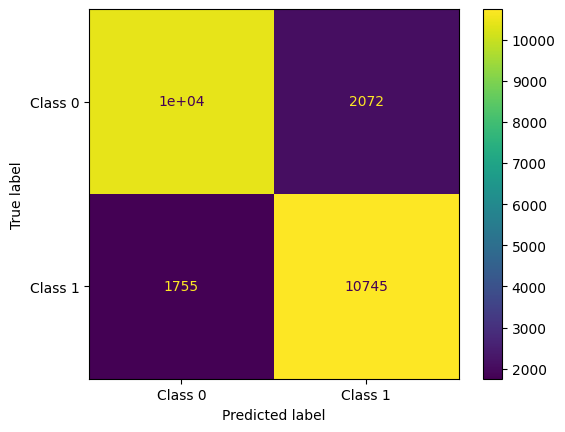

In [53]:
import matplotlib
disp.plot()

In [54]:
# Inspect misclassified samples
for idx, (pred, label) in enumerate(zip(predicted_labels, tokenized_datasets["test"]["label"])):
    if pred != label:
        print(f"Index: {idx}, Predicted: {pred}, Actual: {label}")
        print(tokenized_datasets["test"][idx]["text"])

Index: 1, Predicted: 1, Actual: 0
Worth the entertainment value of a rental, especially if you like action movies. This one features the usual car chases, fights with the great Van Damme kick style, shooting battles with the 40 shell load shotgun, and even terrorist style bombs. All of this is entertaining and competently handled but there is nothing that really blows you away if you've seen your share before.<br /><br />The plot is made interesting by the inclusion of a rabbit, which is clever but hardly profound. Many of the characters are heavily stereotyped -- the angry veterans, the terrified illegal aliens, the crooked cops, the indifferent feds, the bitchy tough lady station head, the crooked politician, the fat federale who looks like he was typecast as the Mexican in a Hollywood movie from the 1940s. All passably acted but again nothing special.<br /><br />I thought the main villains were pretty well done and fairly well acted. By the end of the movie you certainly knew who th